## Pitching Stats vs. Series Outcome in Baseball
### Machine Learning Project
By: Lindsey Drumm, April 2025

In [74]:
import pandas as pd
import numpy as np

pitching_data = pd.read_csv('PitchingPost.csv')
series_data = pd.read_csv('post_series.csv')

series_data.head()

,yearID,round,teamIDwinner,lgIDwinner,teamIDloser,lgIDloser,wins,losses,ties
0,1884,WS,PRO,NL,NYP,AA,3,0,0
1,1885,WS,CHC,NL,STL,AA,3,3,1
2,1886,WS,STL,AA,CHC,NL,4,2,0
3,1887,WS,DTN,NL,STL,AA,10,5,0
4,1888,WS,NYG,NL,STL,AA,6,4,0


In [75]:
agg_funcs = {
    'W': 'sum',
    'L': 'sum',
    'G': 'sum',
    'GS': 'sum',
    'CG': 'sum',
    'SHO': 'sum',
    'SV': 'sum',
    'IPouts': 'sum',
    'H': 'sum',
    'ER': 'sum',
    'HR': 'sum',
    'BB': 'sum',
    'SO': 'sum',
    'IBB': 'sum',
    'WP': 'sum',
    'HBP': 'sum',
    'BK': 'sum',
    'BFP': 'sum',
    'GF': 'sum',
    'R': 'sum',
    'SH': 'sum',
    'SF': 'sum',
    'GIDP': 'sum'
}

# group by team and series
grouped = pitching_data.groupby(['yearID', 'round', 'teamID']).agg(agg_funcs)
grouped['ERA'] = (grouped['ER'] * 27) / grouped['IPouts']
grouped['BAOpp'] = grouped['H'] / grouped['BFP']

pitching_data = grouped.reset_index()



In [76]:
# correctly change labels to match across datasets
old_labels = ['NY4', 'SL4', 'NY1', 'BR3', 'LS2', 'CL4', 'CHN']
new_labels = ['NYP', 'STL', 'NYG', 'BRO', 'LOU', 'CLV', 'CHC']
for i in range(0,6):
    old = old_labels[i]
    new = new_labels[i]
    pitching_data['teamID'] = pitching_data['teamID'].str.replace(old, new)


In [78]:
# assign labels based on wins/losses
merged_data = pitching_data.merge(series_data, on=['yearID', 'round'], how='left')
merged_data['won_series'] = merged_data.apply(
    lambda row: 1 if row['W'] > row['L'] else 
                0 if row['L'] > row['W'] else 
                1 if row['teamIDwinner'] == row['teamID'] else 
                0 if row['teamIDloser'] == row['teamID'] else 
                np.nan,
    axis=1
)
merged_data = merged_data.dropna()
merged_data = merged_data.drop(columns=['teamIDwinner', 'lgIDwinner', 'teamIDloser', 'lgIDloser', 'wins', 'losses', 'ties', 'IBB', 'HBP', 'WP', 'BK', 'GF', 'SH', 'SF', 'GIDP', 'GS', 'BAOpp'])

Index(['yearID', 'round', 'teamID', 'W', 'L', 'G', 'CG', 'SHO', 'SV', 'IPouts',
       'H', 'ER', 'HR', 'BB', 'SO', 'BFP', 'R', 'ERA', 'won_series'],
      dtype='object')


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = merged_data.drop(columns=['won_series','yearID', 'round', 'teamID', ])
y = merged_data['won_series']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)[:,1]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


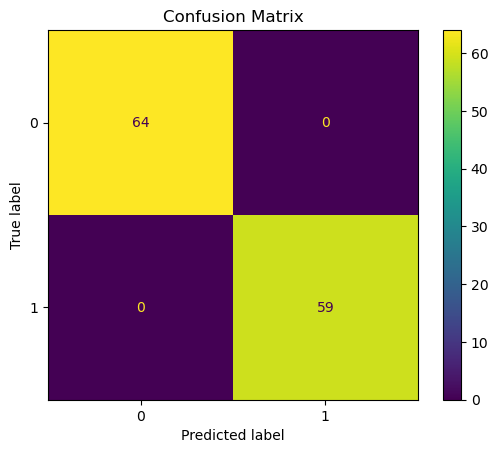

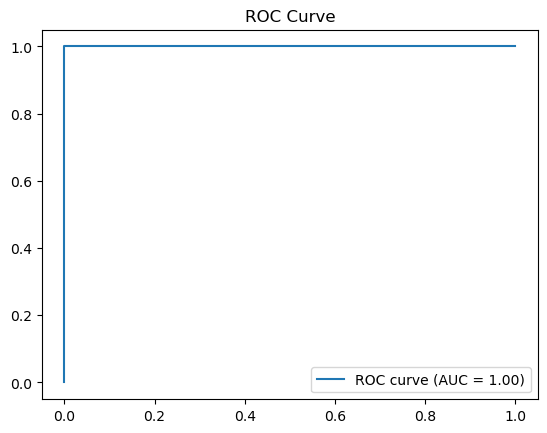

Accuracy score: 1.0


In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
acc = accuracy_score(y_test, y_pred)

disp.plot()
plt.title("Confusion Matrix")
plt.show()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
print(f"Accuracy score: {acc}")